In [1]:
from utils import set_root

from loguru import logger

import numpy as np
import torch

from tqdm import tqdm

from pytorch_lightning import seed_everything

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
import pandas as pd

seed_everything(42)
set_root()

Seed set to 42


Current working directory: /home/guido/github/dev/physioex-private


In [2]:
from physioex.data import TimeDistributedModule, SleepEDF, Shhs

from physioex.train.networks import config as networks
from physioex.train.networks.utils.loss import config as losses

from physioex.models import load_pretrained_model

from physioex.train.networks.utils.target_transform import get_mid_label

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [3]:
# importing
import numpy as np
from loguru import logger
import os

from physioex.train.networks import config
from physioex.data import datasets

from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from loguru import logger

logger.remove()

In [4]:
# model parameters
model_name = "tinysleepnet"
sequence_length = 21

# dataset
picks = ["EEG"]
fold = 0

# dataloader
batch_size = 512
num_workers = 32

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results_dir = f"results/{model_name}/"

In [5]:
# load dataset and model
model = networks[model_name]

dataset = Shhs(
    picks=picks,
    sequence_length=sequence_length,
    # target_transform=model["target_transform"],
    target_transform=get_mid_label,
    preprocessing=model["input_transform"],
)

dataset.split(fold=fold)

dataset = TimeDistributedModule(
    dataset=dataset, batch_size=batch_size, fold=fold, num_workers=num_workers
)

model = load_pretrained_model(
    name=model_name,
    in_channels=len(picks),
    sequence_length=sequence_length,
    softmax=True,
).eval()

/home/guido/github/dev/physioex-private/physioex/models/load.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[ check_table["sequence_length"] == sequence_length ]
/home/guido/github/dev/physioex-private/physioex/models/load.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[ check_table["in_channels"] == in_channels ]
/home/guido/github/dev/physioex-private/physioex/models/load.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ckpt_path = ckpt_path[ check_table["loss"] == loss ]


In [6]:
class MidModel(torch.nn.Module):
    def __init__(self, model):
        super(MidModel, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)[:, int((x.shape[1] - 1) / 2)]


model = MidModel(model)

In [7]:
# compute the metrics on the test set

dataloder = dataset.test_dataloader()

acc = []
cm = []
reports = []

y_pred = []
pred_probas = []
y_true = []

with torch.no_grad():
    # Aggiungi tqdm per mostrare il progresso
    for i, (inputs, labels) in tqdm(enumerate(dataloder), total=len(dataloder)):
        # Calcola le previsioni del modello

        batch_preds = model(inputs.to(device)).cpu().detach()

        if len(batch_preds.size()) == 2:  # in this case the model is seq to seq
            batch_preds = batch_preds.reshape(-1, batch_preds.shape[-1])
            labels = labels.reshape(-1)

        pred_probas.extend(batch_preds)
        y_pred.extend(torch.argmax(batch_preds, dim=1))
        y_true.extend(labels)


y_true = torch.stack(y_true).numpy()
y_pred = torch.stack(y_pred).numpy()
pred_probas = torch.stack(pred_probas).numpy()

 86%|████████▌ | 2535/2949 [2:12:19<21:36,  3.13s/it]  


KeyboardInterrupt: 

Accuracy: 88.61%
Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       417
           1       0.62      0.28      0.39        57
           2       0.87      0.91      0.89       605
           3       0.90      0.86      0.88       233
           4       0.86      0.91      0.88       224

    accuracy                           0.89      1536
   macro avg       0.84      0.78      0.79      1536
weighted avg       0.88      0.89      0.88      1536



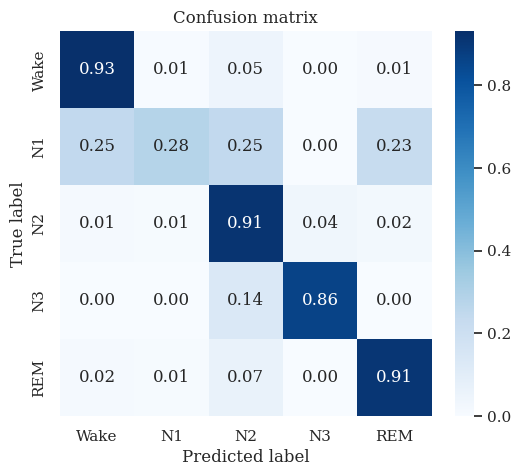

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

print(f"Report:")
print(report)

conf_mat_norm = conf_mat.astype("float") / conf_mat.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 5))
sns.heatmap(
    conf_mat_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["Wake", "N1", "N2", "N3", "REM"],
    yticklabels=["Wake", "N1", "N2", "N3", "REM"],
)
plt.title("Confusion matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

# Save all the results in the results folder
fig.savefig(f"{results_dir}confusion_matrix.png")

with open(f"{results_dir}classification_report.txt", "w") as f:
    # write the first line with the accuracy:
    f.write(f"Accuracy: {accuracy * 100:.2f}%\n")
    # write the report
    f.write("Report:\n")
    f.write(report)